# Creating figures for data from a single group

## Required data 

Each participant should have a separate folder where their spectra and MRS voxels should be stored. The folders should be arranged as follows:

```
project_folder
|   participants.tsv
|
└───data_folder
    |    
    └───sub-01
    |   |    spectrum.tsv
    |   |    spectrum_frequencies.tsv
    |   |    mrs-voxel_mni-space.nii.gz
    |   |    ...
    |
    └───sub-02
    |   |    spectrum.tsv
    |   |    spectrum_frequencies.tsv
    |   |    mrs-voxel_mni-space.nii.gz
    |   |    ...
    |
    |...
```

Participant IDs should be contained in the participants.tsv file. They should be in a column entitled "participant_id".  

Spectrum files should contain a single column with the preprocessed MRS spectra that you wish to display. The related frequencies file should contain a single column with the corresponding frequencies in PPM. 

In this example we use a MEGA-PRESS difference spectra created with the Gannet toolbox (http://www.gabamrs.com/). In the case of Gannet, these files must be written out from the data file created during the analysis. This step will differ depending on the analysis tools that you are using. 

MRS voxels should be in compressed NIFTI format. These should have been aligned to the MNI152 standard space with a 2mm resolution. 


## Make a voxel overlap image

First define the directories and files to be used and load in the participant IDs.

In [2]:
import os
import numpy as np
import pandas as pd

# Project directory
data_dir = '/home/niall/work/MRS-voxel-plot/how-to/'

# Directory to create figures in
fig_dir = os.path.join(data_dir,'figures')

# Check if this figure directory exists, and if not create it
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    
# Define the column in which participant IDs are stored in the tsv file
ID_header = 'participant_id'

# Load in the participant IDs
subjects = pd.read_csv(data_dir+'participants.tsv', delimiter='\t')[ID_header]
n_subs = len(subjects)

# Define the voxel mask filename
mask_name = 'mrs-voxel_mni-space.nii.gz'

To create the overlap image we first need to establish the image dimensions and the affine matrix that defines its orientation. 

In [3]:
import nibabel as ni

# Use the first subject as an examplar for the dimensions and matrix
def get_mask_info(fpath):
    tmp = ni.load(fpath)
    aff = tmp.affine
    dims = tmp.shape
    return(aff,dims)

mask_file = os.path.join(data_dir,'example-data',subjects[0],mask_name)
mask_aff, mask_dims = get_mask_info(mask_file)

We now load the masks for all participants into a single array and calculate the percent overlap.

In [4]:
# Load data
all_mask_data = np.zeros(np.hstack((n_subs,mask_dims)))
for i,sub in enumerate(subjects):
    mask_file = os.path.join(data_dir,'example-data',sub,mask_name)
    all_mask_data[i,:,:,:] = ni.load(mask_file).get_fdata()

# Calculate the overlap between voxels
density = np.sum(all_mask_data, axis = 0)
density = (density/n_subs)*100

# Convert this to nifti image format
density_map = ni.Nifti1Image(density,mask_aff)

The overlap image can now be plotted on the glass brain provided in nilearn (https://nilearn.github.io). 

Plotting is done with matplotlib. This uses inches to define the image dimensions and so we define a helper function so we can input dimensions in cm. 

Here we use the "autumn" colourmap for the plotting but any matplotlib compatible colourmap can be used (see https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html)

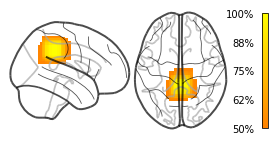

In [5]:
import matplotlib.pyplot as plt
from nilearn import plotting
from matplotlib import ticker

# cm to inch convertor
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

# Define the filename for the image
fig_file = os.path.join(fig_dir,'voxel-density-map_single-group.png')
    
# Plot the figure
fig = plt.figure()
fig.set_size_inches(cm2inch(12,6)) # width, height
ax1 = plt.subplot(111)
plotting.plot_glass_brain(density_map, threshold=0, colorbar=True, axes=ax1, cmap='autumn', 
                          display_mode='xz',annotate=False)
for ax in plt.gcf().axes: # Adjust the colourbar to percentages
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

# Save the figure
fig.savefig(fig_file,bbox_inches='tight',dpi=300)


It can also be useful to have the nifti file of this overlap map to use in other ways so, finally, we create this.

In [14]:
# Save density map NIFTI file
map_file = os.path.join(fig_dir,'voxel_density_map_single-group.nii.gz')
density_map.to_filename(map_file)

## Make a voxel centroid image

We now make a figure showing the voxel centroids for each participant's MRS voxel.

Centroid coordinates are calculated using a helper function from nilearn. This requires separate images in a list structure so we need to reload all the masks.

In [7]:
# Load all masks into a list
all_masks = []
for i, sub in enumerate(subjects):
    mask_file = os.path.join(data_dir,'example-data',sub,mask_name)
    all_masks.append(ni.load(mask_file))
    
# Calculate centroids
all_centres = np.zeros((n_subs,3))
for i in range(n_subs):
    all_centres[i,:] = plotting.find_xyz_cut_coords(all_masks[i])

These centroids can be plotted onto the glass brain. 

Any colour definition that matplotlib can understand can be used. Here we use the basic "red" colour.

Plotting is done through the nilearn plot_connectome function. This expects an adjacency matrix for the points being plotted and so we create a blank one.

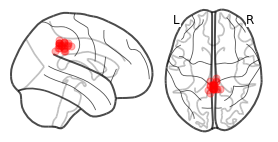

In [11]:
# Create a dummy adjacency matrix
adjacency_matrix = np.zeros((n_subs,n_subs))

# Define the filename for the image
fig_file = os.path.join(fig_dir,'mask-centroids_single-group.png')

# Set colour for points
node_colour = 'red'

# Plot the figure
fig = plt.figure()
fig.set_size_inches(cm2inch(12,6)) # width, height
ax1 = plt.subplot(111)
plotting.plot_connectome(adjacency_matrix=adjacency_matrix, node_coords=all_centres,
  node_size=50, node_color=node_colour, display_mode='xz', node_kwargs={'alpha':0.3},
  axes=ax1,annotate=False)

# Save the figure
fig.savefig(fig_file,bbox_inches='tight',dpi=300)
